# Demo

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import mean_squared_error
import pickle as pkl
from algorithms import matching_pursuit, orthogonal_matching_pursuit, weak_orthogonal_matching_pursuit, sparse_LASSO
from concurrent.futures import ThreadPoolExecutor

## 1. Generate Data

In [2]:
def generate_gaussian_noises_dict(N, d, seed=0):
    np.random.seed(seed)
    gaussian_noises = np.random.normal(size=(d, N))
    norms = np.linalg.norm(gaussian_noises, axis=0, keepdims=True)
    # Create unit-norm vectors
    unit_vectors = gaussian_noises / norms
    return unit_vectors

def generate_sparse_response(gaussian_matrix, m, seed=0):
    np.random.seed(seed)
    indices = np.random.choice(gaussian_matrix.shape[1], size=m, replace=False)
    selected_vectors = gaussian_matrix[:, indices]
    coefficients = np.random.normal(size=(m, 1))  # random coefficients for each selected vector
    y = selected_vectors @ coefficients
    return y, indices, coefficients

def generate_perturbed_response(y, noise_level, seed=0):
    np.random.seed(seed)
    norm_y = np.linalg.norm(y)
    noise = np.random.normal(size=y.shape, scale=norm_y * noise_level)
    y_perturbed = y + noise
    return y_perturbed

def generate_perturbed_responses(y, noise_levels, seed=0):
    return [generate_perturbed_response(y, noise_level, seed) for noise_level in noise_levels]

In [3]:
# Use the functions to generate a Gaussian noise matrix and a sparse response
np.random.seed(0)
N = 100000
d = 300
m = 2
dictionary = generate_gaussian_noises_dict(N, d)
y, indices, coefficients = generate_sparse_response(dictionary, m)
noise_scale = 0.05
y_perturbed = generate_perturbed_response(y, noise_scale)

Check coefs

In [4]:
coefficients

array([[1.87413779],
       [0.630206  ]])

Check indices

In [5]:
indices

array([ 3582, 60498])

## Algorithms

### MP

In [6]:
MP_a, MP_indices, MP_coefficients = matching_pursuit(y, dictionary, 2*m)

MP_a_perturb, MP_indices_perturb, MP_coefficients_perturb = matching_pursuit(y_perturbed, dictionary, 2*m)

print('The indices for each step:', MP_indices_perturb)
print('The coefficients for each step:', MP_coefficients_perturb)

The indices for each step: [3582, 60498, 49122, 34717]
The coefficients for each step: [array([[1.87128833]]), array([[0.53962255]]), array([[0.46872148]]), array([[0.42025955]])]


### OMP

In [7]:
OMP_a, OMP_indices, OMP_coefficients = orthogonal_matching_pursuit(y, dictionary, 2*m)

OMP_a_perturb, OMP_indices_perturb, OMP_coefficients_perturb = orthogonal_matching_pursuit(y_perturbed, dictionary, 2*m)

print('The indices for each step:', OMP_indices_perturb)
print('The coefficients for each step:', OMP_coefficients_perturb)

The indices for each step: [3582, 60498, 49122, 34717]
The coefficients for each step: [[1.793204  ]
 [0.54003735]
 [0.4801365 ]
 [0.42310107]]


### WOMP

In [8]:
WOMP_a, WOMP_indices, WOMP_coefficients = weak_orthogonal_matching_pursuit(y, dictionary, 0.001)

WOMP_a_perturb, WOMP_indices_perturb, WOMP_coefficients_perturb = weak_orthogonal_matching_pursuit(y_perturbed, dictionary, 0.001)

print('The indices for each step:', WOMP_indices_perturb)
print('The coefficients for each step:', WOMP_coefficients_perturb)

The indices for each step: [3582]
The coefficients for each step: [[1.87128833]]


## Performance

In [72]:
%run -i 'testing.py'

Done!


In [73]:
performances = pkl.load(open('results.pkl', 'rb'))

In [74]:
performances.head()

,Algorithm,True sparsity,y,Noise level,Trial index,Real Indices,Real Coefficients,Output Indices,Output Coefficients,a
0,matching_pursuit,2,"[[0.10337851879133514], [-0.002599705490272733...",0.0,0,"[[9313, 31124]]","[[[0.42369065300206393], [-1.274995510672302]]]","[[31124, 9313]]","[[[[-1.24029518]], [[0.42084869]]]]","[[0.1010434211808638], [-0.003076513255595447]..."
1,matching_pursuit,2,"[[0.00666187346015368], [0.00996171809020881],...",0.0,1,"[[33909, 92307]]","[[[-0.24697654788458684], [0.8529569913477981]]]","[[92307, 33909]]","[[[[0.8442019]], [[-0.24666619]]]]","[[0.0065416889762404335], [0.01000652961223143..."
2,matching_pursuit,2,"[[-0.2140468850291173], [0.028631985784027116]...",0.0,2,"[[60805, 57581]]","[[[1.764052345967664], [0.4001572083672233]]]","[[60805, 57581]]","[[[[1.77002106]], [[0.40006818]]]]","[[-0.21481924721998594], [0.028806130977068453..."
3,matching_pursuit,2,"[[-0.13967917039828276], [-0.10577210094079201...",0.0,3,"[[3582, 60500]]","[[[1.6243453636632417], [-0.6117564136500754]]]","[[3582, 60500]]","[[[[1.64374978]], [[-0.61114092]]]]","[[-0.14070005045685705], [-0.10685583066860264..."
4,matching_pursuit,2,"[[-0.04162869142089516], [-0.00541040788671604...",0.0,4,"[[79528, 53876]]","[[[0.44122748688504143], [-0.33087015189408764]]]","[[79528, 53876]]","[[[[0.43132968]], [[-0.33057406]]]]","[[-0.041442967850138346], [-0.0049133606187365..."


In [75]:
# numpy sort by abosulte value
def sorting(numbers_array):
    sorted_numbers = sorted(numbers_array, key=abs)[::-1]
    argsort_idx = list(np.argsort(np.abs(numbers_array))[::-1])
    return sorted_numbers, argsort_idx

In [76]:
# Calculate the mean and standard deviation of the mean squared error for each row
def calculate_mse(row):
    real_y = np.array(row['y'][0]).ravel()
    output_a = np.array(row['a'][0]).ravel()
    mse = mean_squared_error(real_y, output_a)
    return mse

def calculate_correct_rate(row):
    real_indices = np.array(row['Real Indices'][0]).ravel()
    output_indices = np.array(row['Output Indices'][0]).ravel()
    common_elements = set(real_indices).intersection(output_indices)
    return len(common_elements) / len(real_indices)

performances = performances.drop(columns=['Trial index'])
performances['MSE'] = performances.apply(calculate_mse, axis=1)
performances['Intersection Percentage'] = performances.apply(calculate_correct_rate, axis=1)

performances.head()

,Algorithm,True sparsity,y,Noise level,Real Indices,Real Coefficients,Output Indices,Output Coefficients,a,MSE,Intersection Percentage
0,matching_pursuit,2,"[[0.10337851879133514], [-0.002599705490272733...",0.0,"[[9313, 31124]]","[[[0.42369065300206393], [-1.274995510672302]]]","[[31124, 9313]]","[[[[-1.24029518]], [[0.42084869]]]]","[[0.1010434211808638], [-0.003076513255595447]...",5.452681e-06,1.0
1,matching_pursuit,2,"[[0.00666187346015368], [0.00996171809020881],...",0.0,"[[33909, 92307]]","[[[-0.24697654788458684], [0.8529569913477981]]]","[[92307, 33909]]","[[[[0.8442019]], [[-0.24666619]]]]","[[0.0065416889762404335], [0.01000652961223143...",1.444431e-08,1.0
2,matching_pursuit,2,"[[-0.2140468850291173], [0.028631985784027116]...",0.0,"[[60805, 57581]]","[[[1.764052345967664], [0.4001572083672233]]]","[[60805, 57581]]","[[[[1.77002106]], [[0.40006818]]]]","[[-0.21481924721998594], [0.028806130977068453...",5.965434e-07,1.0
3,matching_pursuit,2,"[[-0.13967917039828276], [-0.10577210094079201...",0.0,"[[3582, 60500]]","[[[1.6243453636632417], [-0.6117564136500754]]]","[[3582, 60500]]","[[[[1.64374978]], [[-0.61114092]]]]","[[-0.14070005045685705], [-0.10685583066860264...",1.042196e-06,1.0
4,matching_pursuit,2,"[[-0.04162869142089516], [-0.00541040788671604...",0.0,"[[79528, 53876]]","[[[0.44122748688504143], [-0.33087015189408764]]]","[[79528, 53876]]","[[[[0.43132968]], [[-0.33057406]]]]","[[-0.041442967850138346], [-0.0049133606187365...",3.449324e-08,1.0


In [77]:
performances_summary = performances.groupby(['Algorithm','True sparsity', 'Noise level']).agg({'MSE': 'mean', 'Intersection Percentage': 'mean'}).reset_index()
performances_summary.head()

,Algorithm,True sparsity,Noise level,MSE,Intersection Percentage
0,matching_pursuit,2,0.00,0.000003,1.000
1,matching_pursuit,2,0.01,0.000006,0.975
2,matching_pursuit,2,0.05,0.000105,0.875
3,matching_pursuit,2,0.10,0.003808,0.700
4,matching_pursuit,5,0.00,0.000021,0.930


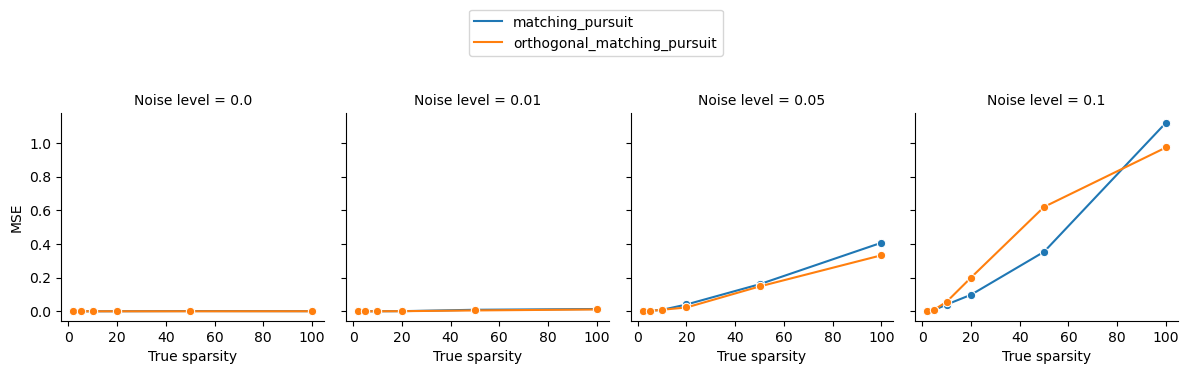

In [78]:
# Visualization

import matplotlib.pyplot as plt
import seaborn as sns

g = sns.FacetGrid(performances_summary, col="Noise level")
g.map_dataframe(sns.lineplot, x="True sparsity", y="MSE", hue="Algorithm", marker='o')

plt.legend(bbox_to_anchor=(-1.7, 1.5), loc=2, borderaxespad=0.)


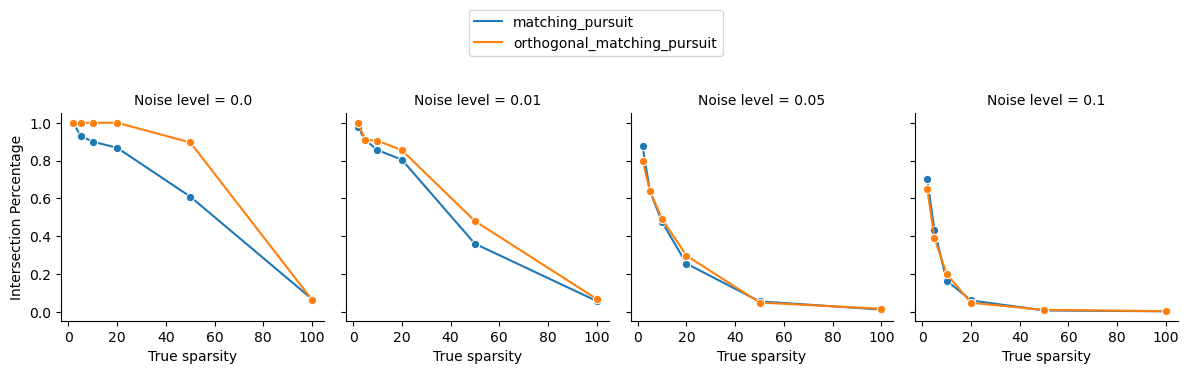

In [79]:
g = sns.FacetGrid(performances_summary, col="Noise level")
g.map_dataframe(sns.lineplot, x="True sparsity", y="Intersection Percentage", hue="Algorithm", marker='o')

plt.legend(bbox_to_anchor=(-1.7, 1.5), loc=2, borderaxespad=0.)

# Lasso

In [31]:
LASSO_residual, LASSO_indices, LASSO_coefficients = sparse_LASSO(y, dictionary, 0.001)

LASSO_residual_perturb, LASSO_indices_perturb, LASSO_coefficients_perturb = sparse_LASSO(y_perturbed, dictionary, 0.001)